In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math

In [ ]:
dataset = 'cifar10'
cls = 7
num_sigma_points = 100

### Load Data

In [ ]:
if (dataset == 'cifar10'):
  mean = [0.4914, 0.4822, 0.4465]
  std = [0.2023, 0.1994, 0.2010]
  normalize = transforms.Normalize(mean, std)
  transform1 = transforms.Compose([
      transforms.ToTensor(),
      normalize,
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomCrop(32, padding=4)
  ])


  transform_sig = transforms.Compose([
      normalize,
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomCrop(32, padding=4)
  ])
  transform2 = transforms.Compose([transforms.ToTensor(), normalize])

  batch_size = 500

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform1)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
elif (dataset == 'mnist'):
  mean = [0.131]
  std = [0.289]
  normalize = transforms.Normalize(mean, std)
  transform = transforms.Compose([transforms.ToTensor()])

  trainset = torchvision.datasets.MNIST('./data',
                              train=True,
                              download=True,
                              transform=transform, )
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=410,
                                            shuffle=True, num_workers=2)
  testset = torchvision.datasets.MNIST('./data',
                              train=False,
                              download=True,
                              transform=transform)
  
  testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=500,
                                         shuffle = False,
                                         num_workers=2)
  classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

shape = trainset.data[0].shape

Files already downloaded and verified
Files already downloaded and verified


### Sigma Points Class

In [ ]:
import torch
from torch import Tensor
from typing import Optional, List
import math


class SigmaPoints():
    def __init__(self, X: Tensor, k: Optional[int] = None, device=None) -> None:
        """
        Class to compute (k + 1) sigma points using an approach similar to that used
        in the Unscented Transform. It is expected that k << m and k << d, where m, d
        are the number of examples and features respectively. k sigma points are computed
        using the top k / 2 projection coefficients produced by PCA for each sample.

        Then, computed points are mapped back to d-dimensional space using a linear
        combination of the top k / 2 principal directions. 


        Args:
            X (Tensor): tensor of shape (m, d), where m = # samples and d = # features
            y (Tensor): tensor of shape (m,), consisting of labels of X
            k (int, Optional): number of non-mean sigma points to compute
        """

        self.k = k
        if not k:
            self.k = X.shape[1] // 20
        if not device:
            device = "cpu"

        self.num_samples = X.shape[0]

        X_centered, self.mean = SigmaPoints.__center(X.float().to(device))

        low_dim_sig_points = self.__low_dim_sig_points(
            self.__compute_proj_matrix(X_centered.to(device), self.k // 2)[1])

        self.sig_points = self.mean.repeat(2*(self.k//2)+1, 1).to(device)

        self.labels = None
        

        self.__cast_high_dim(low_dim_sig_points.to(device))

    @staticmethod
    def __center(X: Tensor, mean: Optional[Tensor] = None):
        if (not mean):
            row_means = torch.mean(X, 0)
        else:
            row_means = mean 
        A = X - row_means
        return A, row_means

    def __compute_proj_matrix(self, centered: Tensor, k, update_orig_restricted_points = True):
        _, D, Vh = torch.linalg.svd(centered, full_matrices=False)

        V = Vh.mH
        if (V.shape[1] < k//2):
            self.k = V.shape[1]*2 + 1
            raise RuntimeWarning("Matrix rank < # of requested Sigma Points.\
            # of sigma points automatically reduced.")

        if (update_orig_restricted_points):
            self.V_restricted = V[:, :self.k // 2]
        
        # Computes X*V[:, :k/2] = (U*D)[:, :k/2]
        proj_matrix = centered @ V[:, :self.k // 2]

        return V[:, :self.k // 2], proj_matrix

    def __low_dim_sig_points(self, proj_matrix: Tensor):
        assert (self.num_samples, self.k // 2) == proj_matrix.shape

        centered_proj_matrix, proj_mean = SigmaPoints.__center(proj_matrix)
        corr_proj_matrix = centered_proj_matrix.T @ centered_proj_matrix
        
        low_dim_sig_points = proj_mean.repeat(2*(self.k//2) + 1, 1)

        L = torch.linalg.cholesky(
            corr_proj_matrix/(centered_proj_matrix.shape[0] - 1))
        
        sqrt_d = math.sqrt(self.k // 2)

        m = self.k // 2

        for i in range(1, 2*m + 1):
            if i <= m:
                low_dim_sig_points[i] += sqrt_d*L[i - 1]
            else:
                low_dim_sig_points[i] -= sqrt_d*L[i - m - 1]

        return low_dim_sig_points

    def __cast_high_dim(self, low_dim_sig_points: Tensor):
        assert low_dim_sig_points.shape[1] == self.V_restricted.shape[1]

        m = self.k // 2
        high_dim_sig_points = self.V_restricted @ low_dim_sig_points.T

        for i in range(2*m + 1):
            self.sig_points[i] += high_dim_sig_points.T[i]

    def generate_labels(self, examples: Tensor, example_labels: Tensor, mode: str = 'nearest', num_neighbors: int = 20, dimensionality_reduction = None,
                        input_encoding: str = 'label', output_encoding: str = 'sparse', num_classes: Optional[int] = None, device = "cuda") -> None:
        """

        Computes labels for the set of sigma points using set of labeled examples.
        Depending on ```mode```, uses either a nearest neighbors based Gaussian
        affinity scheme, per-class mean, or uses all examples.

        Output labels are constructed as vectors lying on the appropriate simplex.
        If output_encoding is sparse and inputs targets are label encoded, then the
        length of vectors is inferred from num_classes (all labels must have values < num_classes). Else, if
        output_encoding is dense and inputs targets are label encoded, then the
        length of label vectors is number of unique labels.

        Args:
            examples (Tensor): _description_
            example_labels (Tensor): _description_
            num_neighbors (int, optional): _description_. Defaults to 5.
            input_encoding (str, optional): _description_. Defaults to 'label'.
            output_encoding (str, optional): _description_. Defaults to 'sparse'.
            mode (str, optional): _description_. Defaults to 'nearest'.
        """
        if (input_encoding == "label"):
            if (output_encoding == "sparse"):
                label_len = num_classes
            else:
                label_len = len(torch.unique(example_labels))
            self.labels = torch.zeros((self.sig_points.shape[0], label_len))

      
            self.__compute_labels(examples, example_labels, label_len, mode = mode, num_neighbors = num_neighbors, device = device)

    def __compute_labels(self, examples, example_labels, label_len, mode = 'nearest', dimensionality_reduction = None, num_neighbors = 20, device = "cuda"):
        if mode == 'nearest':
            all_data = torch.cat((examples.to(device), self.sig_points.to(device)), dim = 0)
            all_data_centered, all_data_means = SigmaPoints.__center(all_data.to(device))
            _, _, Vh = torch.linalg.svd(all_data_centered, full_matrices= False)

            V = Vh.mH

            if (not dimensionality_reduction):
              V_restricted = V[:, :self.k]
            else:
              V_restricted = V[:, :dimensionality_reduction]
            mean_subtracted_examples = examples.to(device) - all_data_means.to(device)
            mean_subtracted_sig_points = self.sig_points.to(device) - all_data_means.to(device)
            
            examples_proj_matrix = mean_subtracted_examples @ V_restricted.to(device)
            sig_points_proj_matrix = mean_subtracted_sig_points @ V_restricted.to(device)
            

            neigh = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree')
            neigh.fit(examples_proj_matrix.cpu())
            distances, indices = neigh.kneighbors(sig_points_proj_matrix.cpu())
            distances /= 2*(examples_proj_matrix.shape[1]- 1)**2
            

            for i in range(self.k + 1):
                similarity_tensor = torch.zeros(num_neighbors) + distances[i]
                similarity_tensor = torch.exp(-similarity_tensor)
                classes_present = example_labels[indices[i]]
              
                z_sig_pt = torch.zeros(label_len)
                for j in range(label_len):
                  relevant_similarities = similarity_tensor[classes_present == j]
                  z_sig_pt[j] = torch.sum(relevant_similarities)

                exp_z_sig_pt = torch.exp(z_sig_pt)
                normalization = torch.sum(exp_z_sig_pt)

                self.labels[i] += exp_z_sig_pt / normalization

            
            


### MNIST/CIFAR10/FashionMNIST Testing

In [ ]:
y = np.array(trainset.targets)
pos_i = np.argwhere(y == cls)
if (dataset == 'cifar10'):
  x_i = torch.from_numpy(trainset.data).flatten(1, -1)[pos_i]
  examples = torch.from_numpy(trainset.data).flatten(1, -1)
  labels = torch.Tensor(trainset.targets)
elif (dataset == 'mnist'):
  x_i = trainset.data.flatten(1, -1)[pos_i]
  examples = (trainset.data).flatten(1, -1)
  labels = trainset.targets

x_i = np.squeeze(x_i, axis= 1)
num_samples = len(x_i)
k = num_sigma_points

sig_points = SigmaPoints(x_i[:num_samples], k = k, device = "cuda")

In [ ]:
sig_points.generate_labels(examples, labels, num_classes = 10, num_neighbors = 25)

In [ ]:

def get_title(labels, classes, largest_k = 3):
  out = "Largest probs ("
  sorted_label_inds = labels.argsort(descending = True)[:largest_k]
  for label_ind in sorted_label_inds:
    out += f"{classes[label_ind]}: {round(float(labels[label_ind]), 2)} "
  
  return out[:-1] + ")"

tensor(255.) tensor(0.)


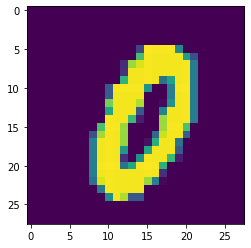

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.02
 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.02 0.04 0.07 0.13 0.2
 0.26 0.31 0.33 0.3  0.25 0.18 0.11 0.05 0.02 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.01 0.02 0.06 0.12 0.22 0.34 0.49
 0.62 0.71 0.75 0.7  0.59 0.44 0.28 0.16 0.07 0.02 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.02 0.06 0.14 0.26 0.41 0.58 0.74
 0.86 0.93 0.95 0.93 0.85 0.69 0.5  0.31 0.15 0.05 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0

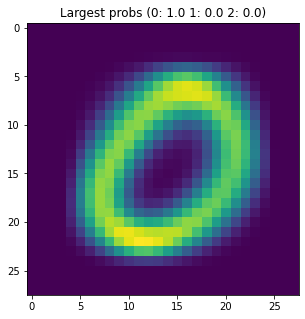

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#mean_x_i = x_i[:100].float().mean(axis = 0)
specific_x_i = x_i[2].float()

shape = None
if (dataset == 'mnist'):
  shape = (28, 28)
elif (dataset == 'cifar10'):
  shape = (32, 32, 3)

plt.imshow(np.interp(specific_x_i, (specific_x_i.min(), specific_x_i.max()), (0, +1)).reshape(shape))
print(specific_x_i.max(), specific_x_i.min())
plt.show()
for i in range(k + 1):
  a = sig_points.sig_points[i].cpu().numpy()
  plt.figure(figsize=(5,5))
  plt.imshow(np.interp(a, (a.min(), a.max()), (0, +1)).reshape(shape))
  print(np.round(np.interp(a, (a.min(), a.max()), (0, +1)), decimals= 2))
  plt.title(get_title(sig_points.labels[i], classes, largest_k = 3))
  plt.show()
  break

### Loading ImageNette

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

items = get_image_files(path)

In [ ]:
splitter = GrandparentSplitter()
splits = splitter(items)
train,valid = (items[i] for i in splits)

In [ ]:
from PIL import Image

In [ ]:
def open_img(fn:Path): return Image.open(fn).copy()
def img2tensor(im:Image.Image): return TensorImage(array(im)[None])

tfms1 = [[open_img, img2tensor, ToTensor, IntToFloatTensor, torch.squeeze],
        [parent_label, Categorize()]]

train_ds1 = Datasets(train, tfms1)

In [ ]:
train[0]

Path('/root/.fastai/data/imagenette2-160/train/n01440764/n01440764_7889.JPEG')

In [ ]:
xs, ys = [], []
for x, y in train_ds1:
  if (len(x.shape) == 3):
    x = torch.permute(x, dims = (2, 0, 1)).float()
    xs.append(x)
    ys.append(y)

In [ ]:
tfms2 = [[transforms.Normalize(*imagenet_stats), 
          transforms.RandomCrop((160, 160)), 
          lambda x: torch.permute(x, dims = (1, 2, 0))],[]]
train2 = xs

In [ ]:
train_ds2 = Datasets(train2, tfms2)

In [ ]:
for x, y in train_ds2[:10]:
  a = x.numpy()
  plt.imshow(np.interp(a, (a.min(), a.max()), (0, +1)))
  plt.show()


In [ ]:
examples, labels = [], [int(y) for y in ys]
del xs, train2
del ys
for (x, _) in train_ds2:
    examples.append(x)


In [ ]:
examples = torch.stack(examples)
labels = torch.tensor(labels)

In [ ]:
cls = 3
y = np.array(labels)
pos_i = np.argwhere(y == cls)
x_i = examples.flatten(1, -1)[pos_i]

x_i = np.squeeze(x_i, axis= 1)
num_samples = len(x_i)
k = 60

sig_points = SigmaPoints(x_i[:num_samples], labels, k = k, device = "cuda")

torch.Size([846, 30])
torch.Size([30, 30])
torch.Size([76800, 61]) torch.Size([76800, 30]) torch.Size([61, 30])


TensorImage(2.6400) TensorImage(-2.1179)


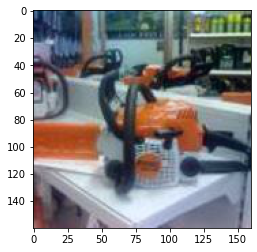

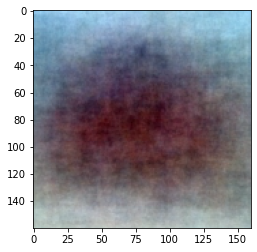

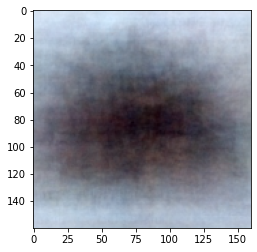

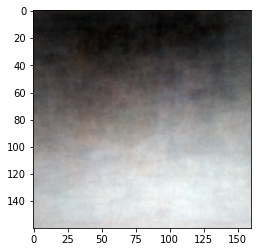

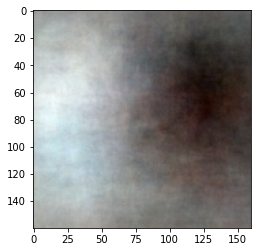

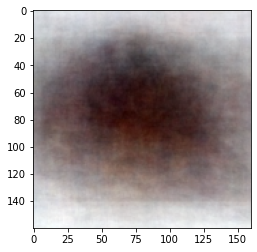

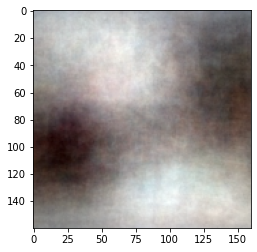

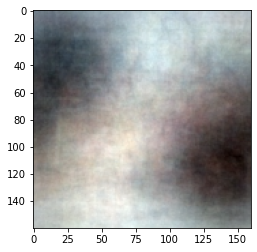

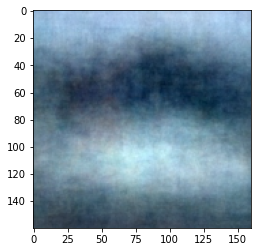

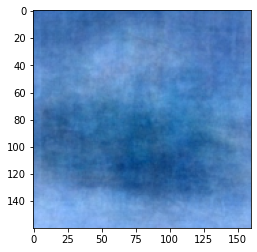

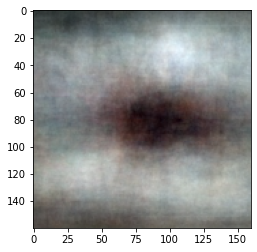

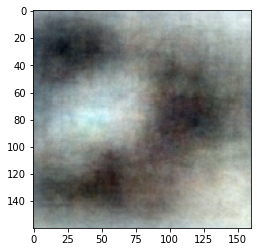

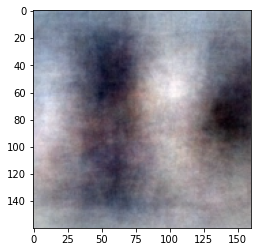

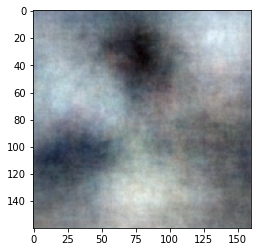

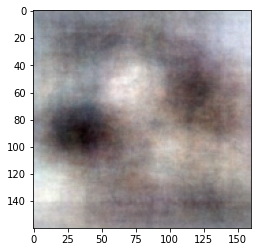

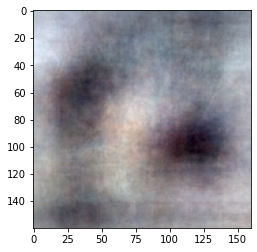

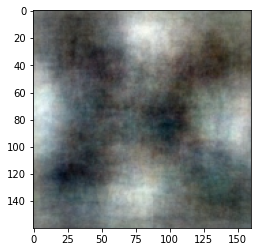

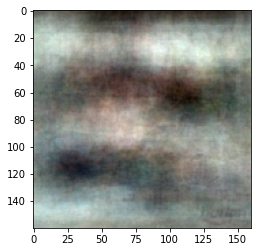

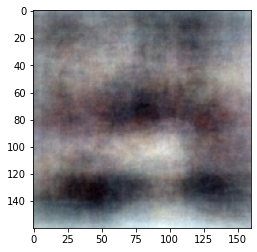

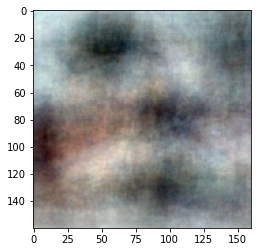

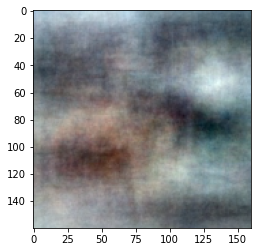

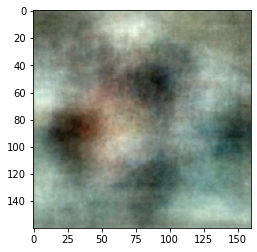

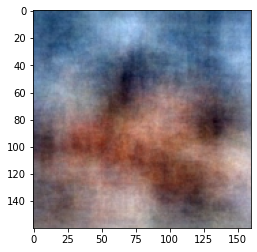

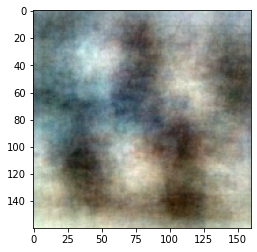

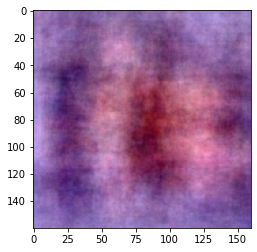

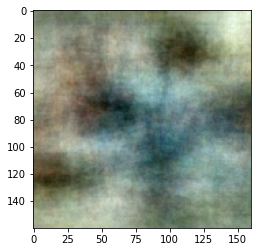

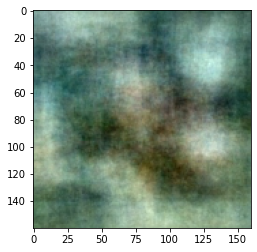

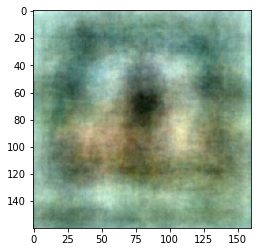

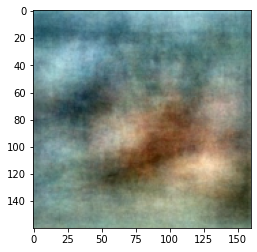

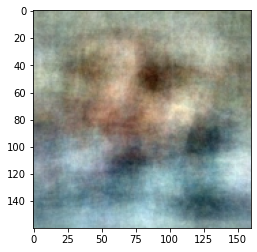

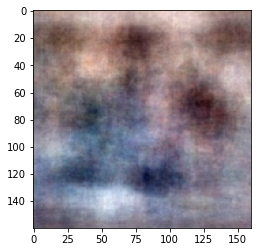

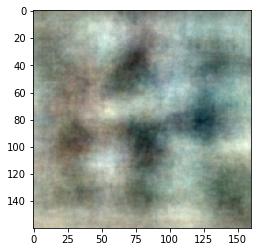

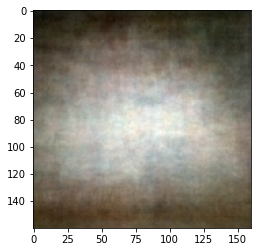

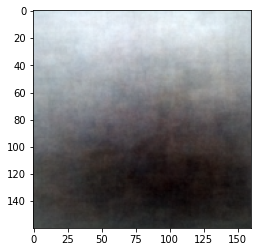

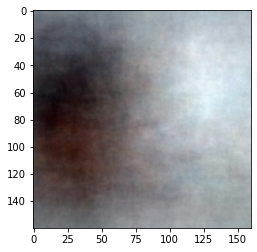

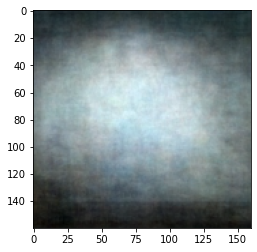

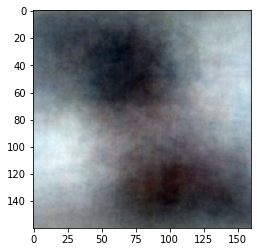

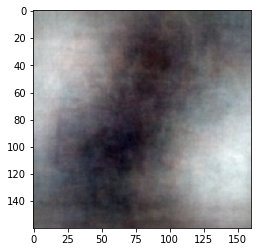

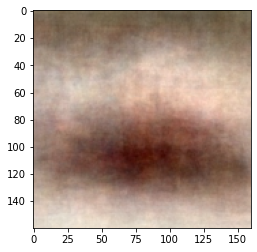

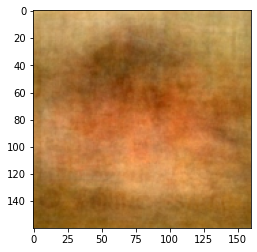

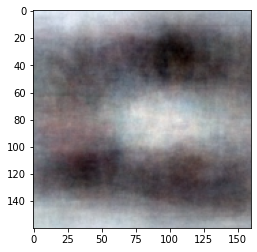

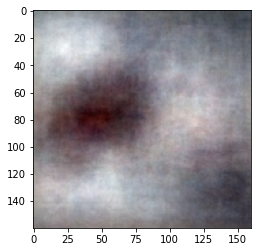

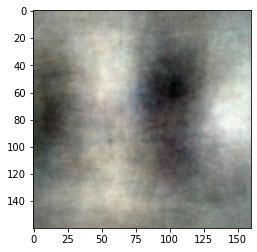

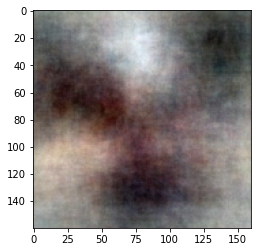

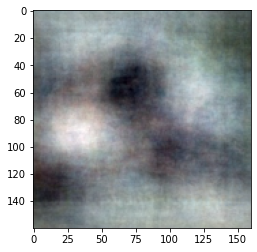

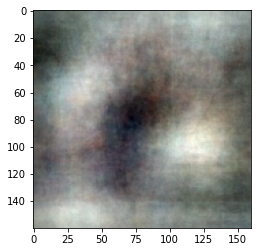

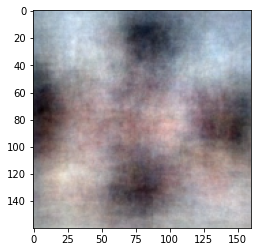

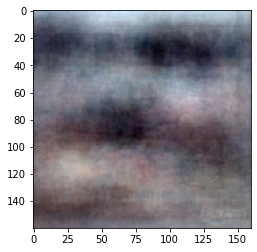

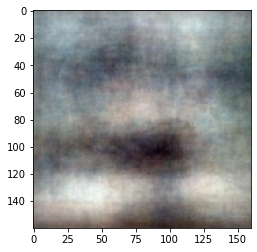

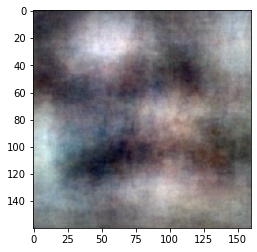

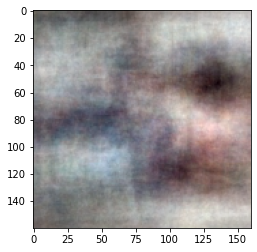

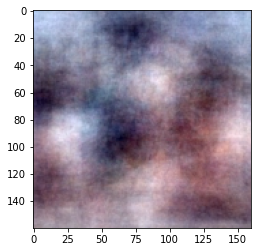

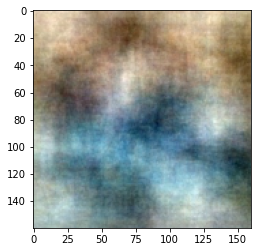

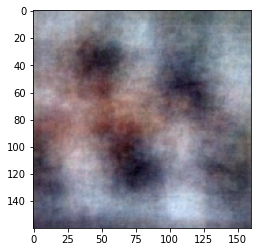

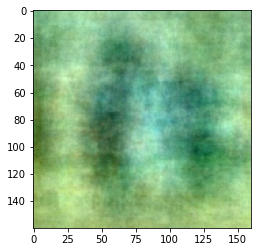

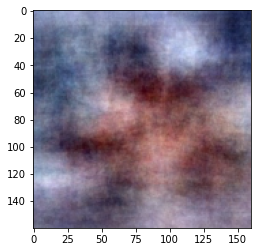

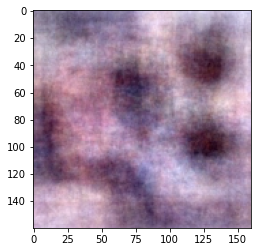

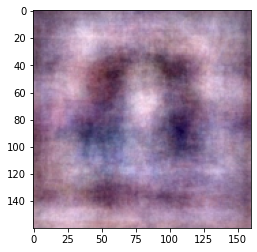

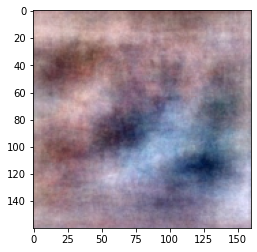

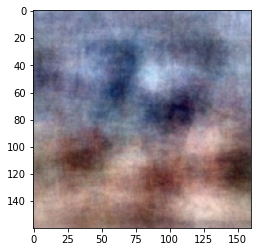

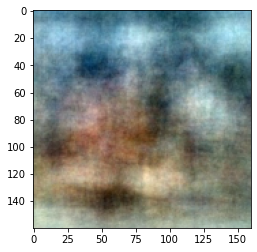

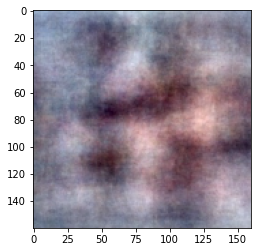

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


#mean_x_i = x_i[:100].float().mean(axis = 0)
mean_x_i = x_i[2].float()


plt.imshow(np.interp(mean_x_i, (mean_x_i.min(), mean_x_i.max()), (0, +1)).reshape(160, 160, 3))
print(mean_x_i.max(), mean_x_i.min())
plt.show()
for i in range(k + 1):
  a = sig_points.sig_points[i].cpu().numpy()
  plt.imshow(np.interp(a, (a.min(), a.max()), (0, +1)).reshape(160,160, 3))
  plt.show()

### KNN Torch Geometric

In [ ]:
x = torch.Tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                  [-1, 1], 
                  [1, -1], 
                  [1, 1]])
y = torch.Tensor([[-1, 0], [1, 0]])
assign_index = knn(x, y, 2, cosine = False)

In [ ]:
closest_samples = x[assign_index[1]] 

In [ ]:
ys = torch.repeat_interleave(y, 2, dim = 0)

In [ ]:
np.exp(-torch.norm((closest_samples - ys), dim = 1, p = 2))

tensor([0.3679, 0.3679, 0.3679, 0.3679])

In [ ]:
y = torch.Tensor([[-1, 0], [1, 0]])
y / 3*torch.max(torch.abs(y), axis = 1)[0]

tensor([[-0.3333,  0.0000],
        [ 0.3333,  0.0000]])

In [ ]:
closest_samples

tensor([[-1., -1.],
        [-1.,  1.],
        [ 1., -1.],
        [ 1.,  1.]])

## Training with Sigma Points

In [ ]:
def scale_0_max(X: Tensor, max_val = 1):
  X_cpu = X.cpu()
  out =  np.zeros(tuple(X_cpu.shape))
  rows = X.shape[0]
  for row in range(rows):
    out[row] = np.interp(X_cpu[row], (X_cpu[row].min(), X_cpu[row].max()), (0, +1))
  return torch.from_numpy(out)


In [ ]:
Xs = None
ys = None

if (dataset == 'cifar10'):
    examples = torch.from_numpy(trainset.data).flatten(1, -1)
    labels = torch.Tensor(trainset.targets)
elif (dataset == 'mnist'):
    examples = (trainset.data).flatten(1, -1)
    labels = trainset.targets

for cls in range(10):
  print(f"Computing Sigma Points for Class: {cls}")
  y = np.array(trainset.targets)
  pos_i = np.argwhere(y == cls)
  if (dataset == 'cifar10'):
    x_i =  torch.from_numpy(trainset.data).flatten(1, -1)[pos_i]
  elif (dataset == 'mnist'):
    x_i = trainset.data.flatten(1, -1)[pos_i]

  x_i = np.squeeze(x_i, axis = 1)
  k = num_sigma_points

  sig_points = SigmaPoints(x_i, k = k, device = "cuda")
  sig_points.generate_labels(examples, labels, num_neighbors = 30, num_classes= 10)
  if Xs == None:
    if (dataset == "cifar10"):
      Xs = scale_0_max(sig_points.sig_points).view(-1, *shape[::-1])
    elif (dataset == "mnist"):
      Xs = scale_0_max(sig_points.sig_points).view(-1, 1, *shape)
    ys = sig_points.labels
  else:
    if (dataset == "cifar10"):
      Xs = torch.cat((Xs, scale_0_max(sig_points.sig_points).view(-1, *shape[::-1])))
    elif (dataset == "mnist"):
      Xs = torch.cat((Xs, scale_0_max(sig_points.sig_points).view(-1, 1, *shape)))
    ys = torch.cat((ys, sig_points.labels))
  


Computing Sigma Points for Class: 0
Computing Sigma Points for Class: 1


KeyboardInterrupt: ignored

In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [ ]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
z        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [ ]:
sig_pts_trainset = CustomTensorDataset(tensors = (Xs, ys), transform = transform_sig)
sig_pts_loader = DataLoader(sig_pts_trainset, batch_size=512, shuffle = True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary


import torch
import torch.nn as nn
import numpy as np
import torch.nn.init as init
import torch.nn.functional as F
import os, sys, pdb, tqdm, random, json, gzip, bz2
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import importlib
import copy
import argparse
from torchvision import transforms, datasets


class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, num_classes = 10, c1=96, c2=144):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co, affine=True))

        self.m = nn.Sequential(
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            convbn(c2,num_classes,1,1),
            nn.AvgPool2d(8),
            View(num_classes))

        # print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)


#We are tesing our model on MNIST dataset which is 1x28x28 insize so we have to change C5 layer in FC layer becasue at this stage 
#pixel size would be 16x5x5 so we can not apply kernel of 5x5 

class lenet(nn.Module):
    def __init__(self):
        super(lenet,self).__init__()
        #Here, we are plementing those layers which are having learnable parameters.
        #Start implementation of Layer 1 (C1) which has 6 kernels of size 5x5 with padding 0 and stride 1
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5))
        
        #Start implementation of Layer 3 (C3) which has 16 kernels of size 5x5 with padding 0 and stride 1
        
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = (5,5))
        
        #Start implementation of Layer 5 (C5) which is basically flattening the data 
            
        self.L1 = nn.Linear(16*5*5, 120)
       # self.L1 = nn.Linear(256, 120)
        
        #Start implementation of Layer 6 (F6) which has 85 Linear Neurons and input of 120
        
        self.L2 = nn.Linear(120,84)
        
        #Start implementation of Layer 7 (F7) which has 10 Linear Neurons and input of 84
        
        self.L3 = nn.Linear(84,10)
        
        #We have used pooling of size 2 and stride 2 in this architecture 
        
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        
        #We have used tanh as an activation function in this architecture so we will use tanh at all layers excluding F7.
        self.act = nn.Tanh()
        
    #Now we will implement forward function to produce entire flow of the architecture.
    
    def forward(self,x):
        x = self.conv1(x)
        #We have used tanh as an activation function in this architecture so we will use tanh at all layers excluding F7.
        x = self.act(x)
        #Now this will be passed from pooling 
        x = self.pool(x)
        #Next stage is convolution
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        #next we will pass from conv3, here we will not pass data from pooling as per Architecture 
        
        
        #Now the data should be flaten and it would be passed from FC layers. 
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        x = self.act(x)
        x = self.L3(x)
        
        return x
    
def train(model, device, train_loader, criterion, optimizer, epoch):
    sum_loss, sum_correct = 0, 0

    model.train()

    for i, (data, target) in enumerate(train_loader):
        data, target = data.float().to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def val(model, device, val_loader, criterion, labels = 'one-hot'):
    sum_loss, sum_correct = 0, 0

    model.eval()
    # with torch.no_grad():
    for i, (data, target) in enumerate(val_loader):
        data, target = data.float().to(device), target.to(device)

        output = model(data)

        pred = output.max(1)[1]

        if (labels == 'one-hot'):
          highest_p_target = target.max(1)[1]
          sum_correct += pred.eq(highest_p_target).sum().item()
        else:
          sum_correct += pred.eq(target).sum().item()
      
        sum_loss += len(data) * criterion(output, target).item()

    return 1 - (sum_correct / len(val_loader.dataset)), sum_loss / len(val_loader.dataset)


In [ ]:
len(Xs)

In [ ]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = allcnn_t().to(device)

criterion = nn.CrossEntropyLoss().to(device)
num_params = sum(param.numel() for param in model.parameters())
print(num_params)

epochs = 50

optimizer = optim.Adam(model.parameters(), lr = 2e-3)
scheduler = CosineAnnealingLR(optimizer,T_max=epochs, eta_min = 5e-4)

tr_err, tr_loss = val(model, device, sig_pts_loader, criterion)
val_err, val_loss = val(model, device, testloader, criterion, labels = 'label')
print("initial", 'tr_loss', tr_loss, 'val_loss', val_loss,  'tr_err', tr_err, 'val_err', val_err)


for epoch in range(epochs):

    train(model, device, sig_pts_loader, criterion, optimizer, epoch)
    
    tr_err, tr_loss = val(model, device, sig_pts_loader, criterion)
    val_err, val_loss = val(model, device, testloader, criterion, labels = 'label')

    # using cosine annealing scheduler
    scheduler.step()

    print(epoch, 'tr_loss', tr_loss, 'val_loss', val_loss,  'tr_err', tr_err, 'val_err', val_err)
    print("lr", optimizer.param_groups[0]['lr'])


In [ ]:
small_subset_training_samples, small_subset_training_labels = None, None
for i, (X, y) in enumerate(trainloader):
  small_subset_training_samples, small_subset_training_labels = X, y
  break


small_subset_dataset = CustomTensorDataset(tensors = (small_subset_training_samples, small_subset_training_labels), transform = None)
small_subset_loader = DataLoader(small_subset_dataset, batch_size=8, shuffle = True)



In [ ]:
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = allcnn_t(c1 = 64, c2 = 128).to(device)

criterion = nn.CrossEntropyLoss().to(device)
num_params = sum(param.numel() for param in model.parameters())
print(num_params)

epochs = 50

optimizer = optim.Adam(model.parameters(), lr = 2e-3)
scheduler = CosineAnnealingLR(optimizer,T_max=epochs, eta_min = 5e-4)

tr_err, tr_loss = val(model, device, small_subset_loader, criterion, labels = 'label')
val_err, val_loss = val(model, device, testloader, criterion, labels = 'label')
print("initial", 'tr_loss', tr_loss, 'val_loss', val_loss,  'tr_err', tr_err, 'val_err', val_err)


for epoch in range(epochs):

    train(model, device, small_subset_loader, criterion, optimizer, epoch)
    
    tr_err, tr_loss = val(model, device, small_subset_loader, criterion, labels = 'label')
    val_err, val_loss = val(model, device, testloader, criterion, labels = 'label')

    # using cosine annealing scheduler
    scheduler.step()

    print(epoch, 'tr_loss', tr_loss, 'val_loss', val_loss,  'tr_err', tr_err, 'val_err', val_err)
    print("lr", optimizer.param_groups[0]['lr'])
